### Computing Option-Implied RND's using clamped cubic spline interpolation method

This project was created for **educational goals**. The code may be flawed or inaccurate in some aspects; therefore, it should be used exclusively as a **personal study tool**.

The goal was to write a simple python code that: 
- Interpolates and extrapolates the volatility smile data using a cubic spline function that is “clamped” at the endpoints to avoid processing-induced violations of no-arbitragerestrictions
- Computes RNDs given suitable implied volatility smile


Note: This project was based on the article "A Simple and Reliable Way to Compute Option-Based Risk-Neutral Distributions" written by Allan M. Malz.

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.interpolate import CubicSpline
from scipy.stats import norm
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_theme()

def add_boundary_knots(spline, directions = ["left", "right"]):
    # Adds knots infinitesimally to the left and right with zero 2nd and 3rd derivative
    # Maintains the first derivative from whatever boundary condition was selected
    for direction in directions:

        if direction == "left":
            knot_index = 0
            knot_position = -1
        else:
            knot_index = -1
            knot_position = 1

        x_axis = spline.x[knot_index]
        x_axis_next = np.nextafter(x_axis, x_axis+knot_position)
        y_axis = spline(x_axis)
        slope = spline(x_axis,nu=1)
        y_axis_next = y_axis+slope*(x_axis_next-x_axis)
        coeffs = np.array([0,0,slope,y_axis_next])
        spline.extend(coeffs[...,None], np.r_[x_axis_next])

def calc_d1(S, K, IV, T, r, q = 0):
    return (np.log(S/K) + (r - q + IV**2/2)*T) / (IV*np.sqrt(T))

def vega(S, K, IV, T, r, q = 0):
    d1 = calc_d1(S, K, IV, T, r)
    return (1/100) * S * np.exp(-q*T) * np.sqrt(T) * (1/np.sqrt(2 * np.pi)) * np.exp(-d1**2/2)

def BSM(S, K, T, r, IV, option = "CALL"):
    d1 = calc_d1(S, K, IV, T, r)
    d2 = d1 - IV* np.sqrt(T)
    
    if option.upper() == "CALL":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option.upper() == "PUT":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def add_greeks(df, s0, T, r, option = "CALL", strike_col = "strikes", iv_col = "implied_vols"):
   
    IV =  df[iv_col]
    K = df[strike_col]
    IV_atm = df.iloc[(K-s0).abs().argsort()[:1]][iv_col].values
    vega_atm = vega(s0, s0, IV_atm, T, r)
    
    df["Call Value"] = BSM(s0, K, T, r, IV, option = "CALL")
    df["Delta"] =  norm.cdf(calc_d1(s0, K, IV, T, r))
    df["Vega"] = (vega(s0, K, IV, T, r))/vega_atm
    
    return df

### Data

The vega for each strike is expressed as its ratio to the ATM vega.

Low vega at the extremes reduces the chance of a violation

In [89]:
r = 0.004
T = 3/12
s0 = 1263.07 * np.exp(r*T)

data_ditc = {"strikes":  np.array([1012.86, 1139.46, 1202.77, 1234.42, 1266.07, 1297.72, 1329.37, 1392.68, 1519.28]),
            "implied_vols":  np.array([25.059, 24.855, 22.949, 21.985, 21.020, 20.064, 19.119, 17.306, 17.348])/100}

moneyness = [*data_ditc["strikes"]/s0]
IV_atm = 21.020/100

data_set = pd.DataFrame.from_dict(data_ditc)
data_set = add_greeks(data_set, s0, T, r)

print(data_set)

   strikes  implied_vols  Call Value     Delta      Vega
0  1012.86       0.25059  254.621036  0.967159  0.184158
1  1139.46       0.24855  142.542065  0.817787  0.664071
2  1202.77       0.22949   93.249372  0.691857  0.883702
3  1234.42       0.21985   71.710672  0.610983  0.962903
4  1266.07       0.21020   52.762417  0.519543  1.000725
5  1297.72       0.20064   36.765952  0.420867  0.982152
6  1329.37       0.19119   23.947049  0.320445  0.898648
7  1392.68       0.17306    7.780428  0.143997  0.569748
8  1519.28       0.17348    0.763451  0.019565  0.119350


### Volatility Smile Interpolation/Extrapolation

In [90]:
#step size of numerical differentiation
step_size = 0.025

#Cubic spline interpolation/extrapolation
cs_vol_fit = CubicSpline(moneyness, data_ditc["implied_vols"], bc_type = "clamped")

#Adds a infinitesimally distanced knot to each extreme
add_boundary_knots(cs_vol_fit)

extrapol_range = 0.2
start = min(moneyness) - extrapol_range
end = max(moneyness) + extrapol_range
extrapol_axis = np.arange(start, end, step_size)

#output
interpol_vol = cs_vol_fit(extrapol_axis)

### Computing Risk Neutral Distribuitons 

In [91]:
#CUMULATIVE DISTRIBUTION - CUBIC SPLINE (FIT) & CONSTANT VOL (BSM)
put_prices_CS = BSM(1, extrapol_axis, T, r, interpol_vol, option = "put")
put_prices_BSM = BSM(1, extrapol_axis, T, r, IV_atm, option = "put")

first_deriv_CS = np.exp(r*T) * np.diff(put_prices_CS)/step_size
first_deriv_BSM = np.exp(r*T) * np.diff(put_prices_BSM)/step_size

#DENSITY FUNCTION APROXIMATION - CUBIC SPLINE (FIT) & CONSTANT VOL (BSM)
dens_aprox_CS = np.diff(first_deriv_CS)
dens_aprox_BSM = np.diff(first_deriv_BSM)

#SMOOTHING PDF FUNCTION
x_axis = extrapol_axis[2:]
y_axis = dens_aprox_CS
smoothing = CubicSpline(x_axis, y_axis, bc_type = "natural")
xnew = np.linspace(x_axis[0], x_axis[-1], 300)
new_dens_CS = smoothing(xnew)


### Plotting Output

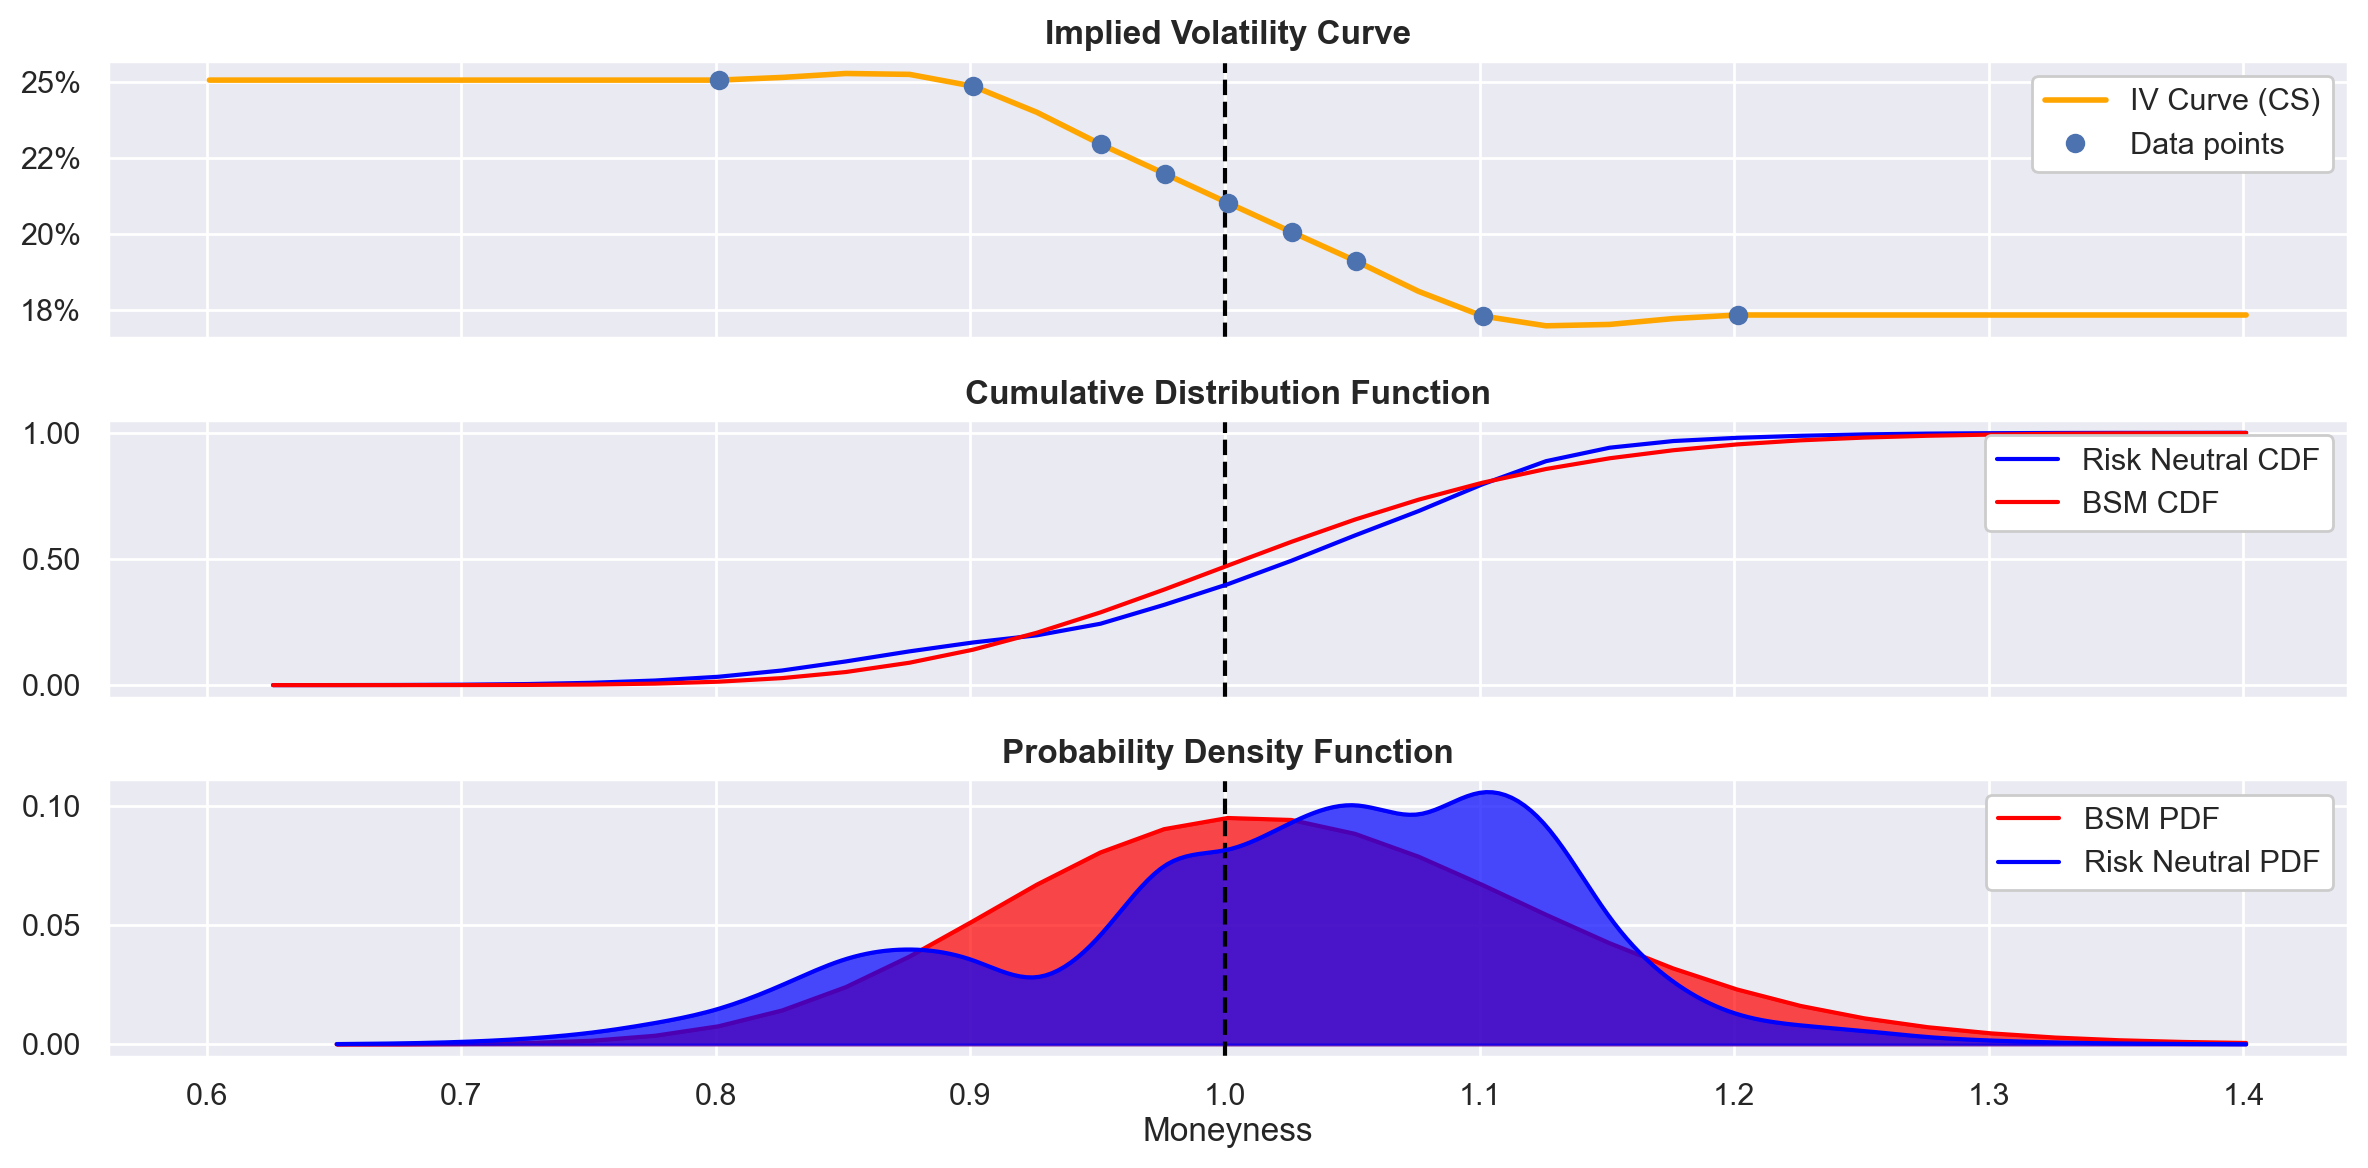

In [92]:
fig, ax = plt.subplots(3,1, figsize = (12, 6), dpi = 200, sharex=True)

ax[0].axvline(1, color = 'black', linestyle='--')
ax[0].plot(extrapol_axis, interpol_vol*100, color = "orange", label="IV Curve (CS)", lw = 2)
ax[0].plot(moneyness, data_ditc["implied_vols"]*100, 'o',color = "b", label='Data points')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

ax[1].axvline(1, color = 'black', linestyle='--')
ax[1].plot(extrapol_axis[1:], first_deriv_CS, color = "blue", label = 'Risk Neutral CDF')
ax[1].plot(extrapol_axis[1:], first_deriv_BSM, color = "red", label = 'BSM CDF')
ax[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

ax[2].axvline(1, color='black', linestyle='--')
ax[2].plot(extrapol_axis[2:], dens_aprox_BSM, color = 'red', zorder = 1, label = 'BSM PDF')
ax[2].fill_between(extrapol_axis[2:], dens_aprox_BSM, color = 'red', alpha = 0.7)
ax[2].plot(xnew, new_dens_CS, color = 'blue', zorder = 10, label = 'Risk Neutral PDF')
ax[2].fill_between(xnew, new_dens_CS, color = 'blue', alpha=0.7)
ax[2].set_xlabel("Moneyness", labelpad = 2.0)

titles = ['Implied Volatility Curve', 'Cumulative Distribution Function', 'Probability Density Function']
for axes, title in [*zip(ax,titles)]:
    axes.legend(loc = "upper right", facecolor='white', framealpha = 1)
    axes.set_title(title, fontsize='medium', fontweight = "bold")

fig.tight_layout()
